In [1]:
import torch
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm

random.seed(42)

In [2]:
data_dir = '../osic-pulmonary-fibrosis-progression'

In [3]:
from preprocess import preprocess_scans
import pickle

if not os.path.exists(f'{data_dir}/preprocessed_scans.pkl'):
    preprocessed_scans = preprocess_scans(data_dir)
    pickle.dump(preprocessed_scans, open(f'{data_dir}/preprocessed_scans.pkl', 'wb'))

Using device: cuda


In [4]:
# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [5]:
# Prepare train and val data
train_datas = pd.read_csv(data_dir + '/train.csv')
test_datas = pd.read_csv(data_dir + '/test.csv')

test_patient_ids = test_datas['Patient'].unique()

# Remove row in train data if patient_id is in test_patient_ids
test_datas = train_datas[train_datas['Patient'].isin(test_patient_ids)]
train_datas = train_datas[~train_datas['Patient'].isin(test_patient_ids)]

# Sort df by patient and then by 'Weeks'
train_datas = train_datas.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value and weeks
patient_id_to_initial_FVC = train_datas.groupby('Patient')['FVC'].first().to_dict()
patient_id_to_initial_weeks = train_datas.groupby('Patient')['Weeks'].first().to_dict()

train_datas, val_datas = train_val_split(train_datas)

# Count the number of scans for each patient
scan_count = {}
test_scan_count = {}
for patient_id in os.listdir(os.path.join(data_dir, 'train')):
    scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'train', patient_id)))
    
    if patient_id in test_patient_ids:
        test_scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'test', patient_id)))

test_patient_id_to_initial_FVC = test_datas.groupby('Patient')['FVC'].first().to_dict()
test_patient_id_to_initial_weeks = test_datas.groupby('Patient')['Weeks'].first().to_dict()

In [6]:
from collections import defaultdict

train_x, train_y = defaultdict(list), defaultdict(list)

for idx, row in train_datas.iterrows():
    train_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    train_y[row['Patient']].append(row['FVC'])

val_x, val_y = defaultdict(list), defaultdict(list)

for idx, row in val_datas.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC'])

test_x, test_y = defaultdict(list), defaultdict(list)

for idx, row in test_datas.iterrows():
    test_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': test_patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': test_patient_id_to_initial_weeks[row['Patient']],
    })
    test_y[row['Patient']].append(row['FVC'])


In [7]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.conv1(scans))
        x = self.pool(x) # num_slices, 32, 128, 128
    
        x = F.relu(self.conv2(x))
        x = self.pool(x) # num_slices, 64, 64, 64
        
        x = F.relu(self.conv3(x))
        x = self.pool(x) # num_slices, 128, 32, 32

        x = F.relu(self.conv4(x))
        x = self.pool(x) # num_slices, 256, 16, 16

        x = F.relu(self.conv5(x))
        x = self.pool(x) # num_slices, 512, 8, 8

        # x = self.global_pool(x) # num_slices, 512, 1, 1

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512*8*8+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.conv1(scans))
        x = nn.MaxPool2d(2, 2)(x) # num_slices, 64, 128, 128

        x = self.conv2(x) # num_slices, 64, 64, 64
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.001, batch_size=128):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), lr=learning_rate
    )

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")
        cnn_model.train()
        fc_model.train()

        patient_count = 0
        accum_loss = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            if patient_count % 8 == 0:
                optimizer.zero_grad()
                accum_loss = 0

            patient_scan_count = scan_count[patient_id]
            features = []
            for i in range(1, patient_scan_count + 1, batch_size):
                scans = []
                for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                    scan = get_preprocessed_scan(data_dir, patient_id, j)
                    if scan is None:
                        continue
                    scan = torch.tensor(scan, dtype=torch.float32, device=device)
                    scans.append(scan)
                scans = torch.stack(scans)
                  
                print(scans.shape)
                features.append(cnn_model.forward(scans))
                print(features[-1].shape)
            features = torch.cat(features)
            features = torch.mean(features, dim=0) # 1024,
            
            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate for all datapoints of patient
            for i in range(len(x)):
                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))

                # accumulate gradient
                loss.backward(retain_graph=True)
                accum_loss += loss.item()

            # Update parameters based on batch of 8 patients
            if patient_count % 8 == 7:
                optimizer.step()
            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {accum_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(accum_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list(val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                features = []
                for i in range(1, patient_scan_count + 1, batch_size):
                    torch.cuda.empty_cache()
                    scans = []
                    for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                        scan = get_preprocessed_scan(data_dir, patient_id, j)
                        if scan is None:
                            continue
                        scan = torch.tensor(scan, dtype=torch.float32, device=device)
                        scans.append(scan)
                    scans = torch.stack(scans)

                    features.append(cnn_model.forward(scans))
                features = torch.cat(features)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [15]:
import matplotlib.pyplot as plt
import math

# window = 0 to remove smoothing
def plot_loss(training_loss, val_loss, window=5):
    # Use sliding window to smooth the loss
    training_loss = [sum(training_loss[i:i+window]) / window for i in range(len(training_loss)-window)]
    val_loss = [sum(val_loss[i:i+window]) / window for i in range(len(val_loss)-window)]

    # Create one row, two col subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].plot(range(len(training_loss)), [math.log(x) for x in training_loss], label='Training Loss')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(range(len(val_loss)), [math.log(x) for x in val_loss], label='Validation Loss', color='orange')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Loss')
    axs[1].legend()

In [16]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_seqblkcnn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8, batch_size=32)
plot_loss(training_loss, val_loss)

Epoch 0


  0%|          | 0/136 [00:00<?, ?it/s]

torch.Size([18, 1, 256, 256])
torch.Size([18, 512])


  1%|          | 1/136 [00:00<01:23,  1.62it/s]

torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])


  1%|▏         | 2/136 [00:02<02:45,  1.24s/it]

torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([28, 1, 256, 256])
torch.Size([28, 512])


  2%|▏         | 3/136 [00:03<03:02,  1.37s/it]

torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([30, 1, 256, 256])
torch.Size([30, 512])


  3%|▎         | 4/136 [00:05<03:11,  1.45s/it]

torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])


  4%|▎         | 5/136 [00:07<03:19,  1.52s/it]

torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([32, 1, 256, 256])
torch.Size([32, 512])
torch.Size([12, 1, 256, 256])
torch.Size([12, 512])


  4%|▎         | 5/136 [00:41<18:08,  8.31s/it]


KeyboardInterrupt: 

In [ ]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_model, fc_model):
    cnn_model.to(device)
    fc_model.to(device)

    cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        features = torch.tensor([], dtype=torch.float32, device=device)
        for i in range(1, patient_scan_count + 1, batch_size):
            scans = []
            for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                scan = get_test_preprocessed_scan(data_dir, patient_id, j)
                if scan is None:
                    continue
                scan = torch.tensor(scan, dtype=torch.float32, device=device)
                scans.append(scan)
            scans = torch.stack(scans)

            batch_scans = scans
            features = torch.cat([features, cnn_model.forward(batch_scans)])

        features = torch.mean(features, dim=0) # 1024,

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

In [ ]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
test_prediction, test_target, loss(test_prediction, test_target)


100%|██████████| 5/5 [00:00<00:00, 10.45it/s]


(tensor([2911.1968, 2910.2361, 2908.3145, 2907.3535, 2904.4712, 2899.6675,
         2887.1772, 2875.6475, 2860.2749, 2670.4512, 2668.5293, 2666.6074,
         2664.6853, 2662.7637, 2656.9980, 2645.4663, 2632.9741, 2617.5989,
         2617.5989, 1947.1580, 1942.3546, 1940.4336, 1938.5127, 1936.5916,
         1930.8320, 1919.3132, 1907.8024, 3314.1389, 3313.1782, 3312.2175,
         3310.2959, 3308.3748, 3301.6511, 3290.1248, 3279.5615, 3263.2373,
         3071.3479, 3064.7734, 3062.8955, 3061.0183, 3059.1409, 3053.5088,
         3042.2454, 3030.9912, 3016.0332]),
 tensor([3020, 2859, 2783, 2719, 2738, 2694, 2708, 2793, 2727, 2739, 2756, 2755,
         2820, 2853, 2716, 2833, 2771, 2628, 2719, 1930, 1936, 1955, 1848, 1897,
         1946, 1862, 1713, 3294, 2777, 2700, 3014, 2661, 2778, 2516, 2432, 2578,
         2925, 2903, 2916, 2976, 2712, 2978, 2908, 2975, 2774]),
 tensor(86800.2031))

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Follow Imagenet architecture (34 layers)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 6

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        ) + nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 11

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 5

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 2

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

100%|██████████| 35/35 [00:01<00:00, 26.76it/s]


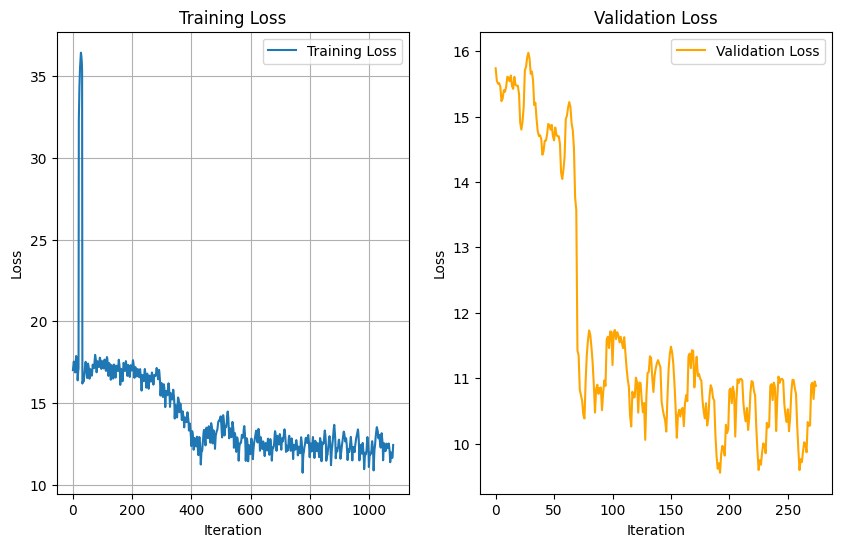

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_imagenet.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8)
plot_loss(training_loss, val_loss)


In [ ]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
list(zip(test_prediction, test_target)), loss(test_prediction, test_target)

100%|██████████| 5/5 [00:00<00:00, 16.55it/s]


([(tensor(2888.9294), tensor(3020)),
  (tensor(2889.3596), tensor(2859)),
  (tensor(2890.2195), tensor(2783)),
  (tensor(2890.6499), tensor(2719)),
  (tensor(2891.9399), tensor(2738)),
  (tensor(2894.0901), tensor(2694)),
  (tensor(2899.6807), tensor(2708)),
  (tensor(2904.8411), tensor(2793)),
  (tensor(2911.7217), tensor(2727)),
  (tensor(2629.8918), tensor(2739)),
  (tensor(2630.7520), tensor(2756)),
  (tensor(2631.6118), tensor(2755)),
  (tensor(2632.4722), tensor(2820)),
  (tensor(2633.3323), tensor(2853)),
  (tensor(2635.9126), tensor(2716)),
  (tensor(2641.0732), tensor(2833)),
  (tensor(2646.6636), tensor(2771)),
  (tensor(2653.5442), tensor(2628)),
  (tensor(2653.5442), tensor(2719)),
  (tensor(1848.7667), tensor(1930)),
  (tensor(1850.9169), tensor(1936)),
  (tensor(1851.7770), tensor(1955)),
  (tensor(1852.6371), tensor(1848)),
  (tensor(1853.4972), tensor(1897)),
  (tensor(1856.0775), tensor(1946)),
  (tensor(1861.2379), tensor(1862)),
  (tensor(1866.3984), tensor(1713)),
 

In [ ]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.input_conv(x))
        x = self.second_conv(x)
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(1, 512)

        return x

  7%|▋         | 1/15 [00:17<04:08, 17.74s/it]

Epoch 0 completed
Training Loss: 28544916.748571426
Validation Loss: 6280236.504166666


 13%|█▎        | 2/15 [00:34<03:46, 17.42s/it]

Epoch 1 completed
Training Loss: 18052226.799513888
Validation Loss: 2268026.711851671


 20%|██        | 3/15 [00:51<03:25, 17.13s/it]

Epoch 2 completed
Training Loss: 5670800.685310872
Validation Loss: 1068001.6760036894


 27%|██▋       | 4/15 [01:10<03:13, 17.61s/it]

Epoch 3 completed
Training Loss: 1478177.8830860395
Validation Loss: 82032.53503074645


 33%|███▎      | 5/15 [01:27<02:53, 17.37s/it]

Epoch 4 completed
Training Loss: 506700.0425916885
Validation Loss: 36074.44791668786


 40%|████      | 6/15 [01:43<02:35, 17.23s/it]

Epoch 5 completed
Training Loss: 373043.74532848067
Validation Loss: 40514.43636927075


 47%|████▋     | 7/15 [02:01<02:18, 17.35s/it]

Epoch 6 completed
Training Loss: 460154.5814640522
Validation Loss: 43684.63024431864


 53%|█████▎    | 8/15 [02:19<02:01, 17.39s/it]

Epoch 7 completed
Training Loss: 422860.59158000525
Validation Loss: 36450.836972501544


 60%|██████    | 9/15 [02:36<01:45, 17.56s/it]

Epoch 8 completed
Training Loss: 306212.7632577267
Validation Loss: 35754.26784697903


 67%|██████▋   | 10/15 [02:53<01:26, 17.29s/it]

Epoch 9 completed
Training Loss: 475892.4268753872
Validation Loss: 42758.30239274767


 73%|███████▎  | 11/15 [03:10<01:08, 17.00s/it]

Epoch 10 completed
Training Loss: 188460.2881650988
Validation Loss: 38309.01177065108


 80%|████████  | 12/15 [03:28<00:52, 17.47s/it]

Epoch 11 completed
Training Loss: 185118.05938945917
Validation Loss: 42144.301623974905


 87%|████████▋ | 13/15 [03:45<00:34, 17.41s/it]

Epoch 12 completed
Training Loss: 271564.1189241661
Validation Loss: 47210.7617547777


 93%|█████████▎| 14/15 [04:02<00:17, 17.27s/it]

Epoch 13 completed
Training Loss: 290191.6171766069
Validation Loss: 43920.247186024986


100%|██████████| 15/15 [04:20<00:00, 17.35s/it]

Epoch 14 completed
Training Loss: 152987.8984055784
Validation Loss: 36436.07903394169


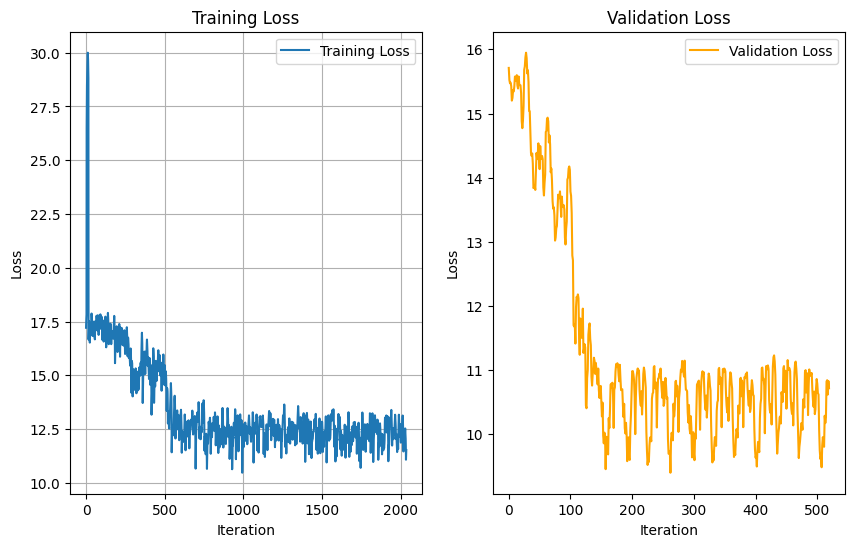

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=15)
plot_loss(training_loss, val_loss)

In [ ]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    # Add batchnorm
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.bn2(self.second_conv(x))
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(1, 512)

        return x

 12%|█▎        | 1/8 [00:20<02:20, 20.13s/it]

Epoch 0 completed
Training Loss: 8412190.819774305
Validation Loss: 1742510.77265625


 25%|██▌       | 2/8 [00:41<02:05, 20.99s/it]

Epoch 1 completed
Training Loss: 1100174.009259993
Validation Loss: 88160.71688902113


 38%|███▊      | 3/8 [01:02<01:43, 20.79s/it]

Epoch 2 completed
Training Loss: 409246.9832361521
Validation Loss: 58854.091657769844


 50%|█████     | 4/8 [01:23<01:24, 21.02s/it]

Epoch 3 completed
Training Loss: 256522.9424790255
Validation Loss: 46644.64707374573


 62%|██████▎   | 5/8 [01:45<01:03, 21.20s/it]

Epoch 4 completed
Training Loss: 449446.5395580988
Validation Loss: 43194.11038554046


 75%|███████▌  | 6/8 [02:05<00:41, 20.99s/it]

Epoch 5 completed
Training Loss: 331142.6477907923
Validation Loss: 57403.33461781343


 88%|████████▊ | 7/8 [02:27<00:21, 21.17s/it]

Epoch 6 completed
Training Loss: 245726.6814440735
Validation Loss: 43601.580966213674


100%|██████████| 8/8 [02:47<00:00, 20.95s/it]

Epoch 7 completed
Training Loss: 310612.6969193086
Validation Loss: 42444.78144902123


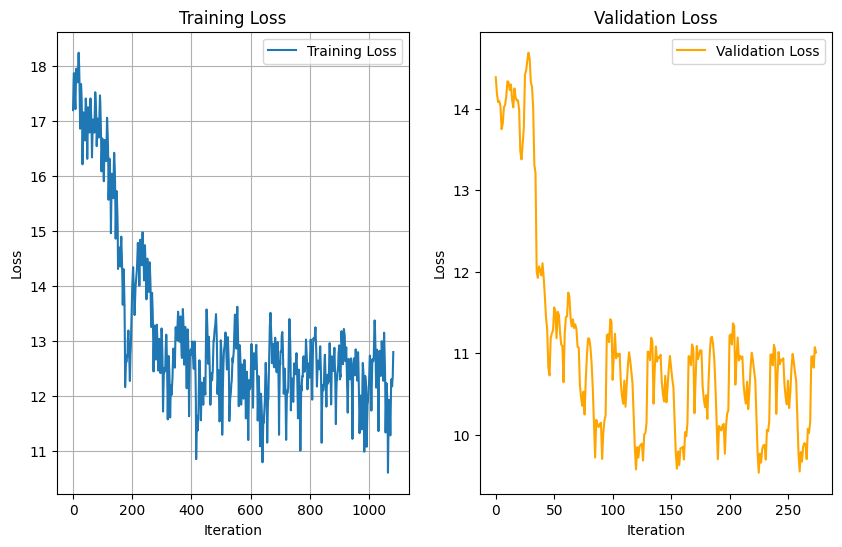

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_bn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8)
plot_loss(training_loss, val_loss)

In [ ]:
from torch import nn
import torch.nn.functional as F

class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 6)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(x.size(0), -1)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=2048+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


  6%|▋         | 1/16 [00:26<06:42, 26.83s/it]

Epoch 0 completed
Training Loss: 1106025.3185762193
Validation Loss: 310250.1910183377


 12%|█▎        | 2/16 [00:52<06:07, 26.26s/it]

Epoch 1 completed
Training Loss: 369222.7925042396
Validation Loss: 68177.45695889856


 19%|█▉        | 3/16 [01:18<05:39, 26.13s/it]

Epoch 2 completed
Training Loss: 234581.18131046003
Validation Loss: 54548.11736842261


 25%|██▌       | 4/16 [01:43<05:09, 25.76s/it]

Epoch 3 completed
Training Loss: 353024.27713433316
Validation Loss: 56887.55768902037


 31%|███▏      | 5/16 [02:10<04:47, 26.16s/it]

Epoch 4 completed
Training Loss: 608163.6381768988
Validation Loss: 32420.399814028293


 38%|███▊      | 6/16 [02:36<04:20, 26.03s/it]

Epoch 5 completed
Training Loss: 201979.9937713536
Validation Loss: 48826.318508221375


 44%|████▍     | 7/16 [03:02<03:54, 26.01s/it]

Epoch 6 completed
Training Loss: 244069.54773299707
Validation Loss: 39723.02897357941


 50%|█████     | 8/16 [03:27<03:24, 25.54s/it]

Epoch 7 completed
Training Loss: 195213.94727029346
Validation Loss: 51904.22171897358


 56%|█████▋    | 9/16 [03:53<02:59, 25.70s/it]

Epoch 8 completed
Training Loss: 343829.9784128518
Validation Loss: 36997.895279015436


 62%|██████▎   | 10/16 [04:17<02:31, 25.20s/it]

Epoch 9 completed
Training Loss: 200570.29970965005
Validation Loss: 43297.59485224618


 69%|██████▉   | 11/16 [04:40<02:03, 24.64s/it]

Epoch 10 completed
Training Loss: 315838.54704092344
Validation Loss: 65323.208772375845


 75%|███████▌  | 12/16 [05:04<01:37, 24.30s/it]

Epoch 11 completed
Training Loss: 251008.7412136491
Validation Loss: 32550.725534542733


 81%|████████▏ | 13/16 [05:29<01:13, 24.56s/it]

Epoch 12 completed
Training Loss: 306028.1240408929
Validation Loss: 43120.28947554694


 88%|████████▊ | 14/16 [05:55<00:50, 25.19s/it]

Epoch 13 completed
Training Loss: 338875.6897001581
Validation Loss: 47144.16521903144


 94%|█████████▍| 15/16 [06:21<00:25, 25.29s/it]

Epoch 14 completed
Training Loss: 202674.62257152132
Validation Loss: 43616.63660211563


100%|██████████| 16/16 [06:46<00:00, 25.42s/it]

Epoch 15 completed
Training Loss: 293974.20172004995
Validation Loss: 49983.17696640491


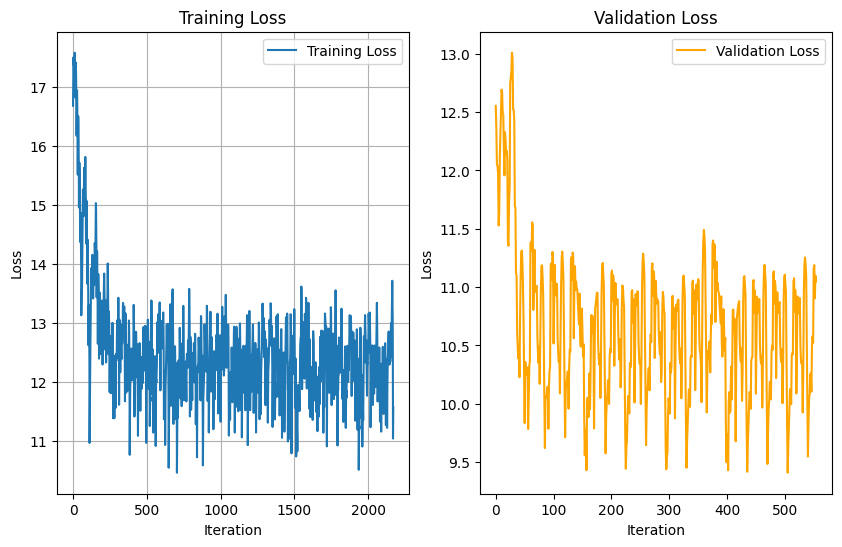

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_152.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=16)
plot_loss(training_loss, val_loss)

In [ ]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

def forward(cnn_model, fc_model, criterion, patient_id, x, y):
    patient_scan_count = scan_count[patient_id]
    features = []
    for i in range(1, patient_scan_count + 1, batch_size):
        scans = []
        for j in range(i, min(i+batch_size, patient_scan_count + 1)):
            scan = get_preprocessed_scan(data_dir, patient_id, j)
            if scan is None:
                continue
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
            scans.append(scan)
        scans = torch.stack(scans)
    
        batch_scans = scans
        features.append(cnn_model.forward(batch_scans))
    features = torch.cat(features)
    features = torch.mean(features, dim=0) # 1024,

    # Accumulate for all datapoints of patient
    accum_loss = 0
    for i in range(len(x)):
        weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
        initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
        initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

        # Forward Pass
        output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
        accum_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))

    del scans, batch_scans, features, weeks, initial_FVC, initial_FVC_weeks, output
    
    return accum_loss


def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.001):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), lr=learning_rate
    )

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")

    for epoch in tqdm(range(epoch)):
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")
        cnn_model.train()
        fc_model.train()

        patient_count = 0
        accum_loss = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in patient_list:
            if patient_count % 8 == 0:
                optimizer.zero_grad()
                accum_loss = 0

            loss = forward(cnn_model, fc_model, criterion, patient_id, train_x[patient_id], train_y[patient_id])
            loss.backward(retain_graph=True)
            accum_loss += loss

            # Update parameters based on batch of 8 patients
            if patient_count % 8 == 7:
                optimizer.step()
            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {accum_loss / max(len(train_x[patient_id]), 1)}\n")
            if len(train_x[patient_id]) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(accum_loss / max(len(train_x[patient_id]), 1))
        
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list(val_x.keys()):
                optimizer.zero_grad()

                x = val_x[patient_id]
                y = val_y[patient_id]

                loss = forward(cnn_model, fc_model, criterion, patient_id, x, y)

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(val_x[patient_id]), 1)}\n")
                val_loss.append(accum_loss / max(len(val_x[patient_id]), 1))

                if len(val_x[patient_id]) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_152.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=16)
plot_loss(training_loss, val_loss)

  0%|          | 0/16 [00:31<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 462.00 MiB. GPU 0 has a total capacity of 15.93 GiB of which 0 bytes is free. Of the allocated memory 29.56 GiB is allocated by PyTorch, and 325.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)